<font size="+3"><strong>5.4. Gradient Boosting Trees</strong></font>

You've been working hard, and now you have all the tools you need to build and tune  models. We'll start this lesson the same way we've started the others: preparing the data and building our model, and this time with a new ensemble model. Once it's working, we'll learn some new performance metrics to evaluate it. By the end of this lesson, you'll have written your first Python module!  

In [1]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
import wqet_grader
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget

wqet_grader.init("Project 5 Assessment")

In [2]:
VimeoVideo("696221191", h="275ffd1421", width=600)

In [2]:
from IPython.display import VimeoVideo

# Prepare Data

All the data preparation for this module is the same as it was last time around. See you on the other side!

## Import

**Task 5.4.1:** Complete the `wrangle` function below using the code you developed in the  lesson 5.1. Then use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.

- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)

In [3]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df

In [4]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Split

**Task 5.4.2:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 

- [What's a <span id='term'>feature matrix</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Combine-multiple-categories-in-a-Series) 

In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


**Task 5.4.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

- [<span id='technique'>Perform a randomized train-test split using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
X,y,test_size=0.2,random_state=42
)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## Resample

**Task 5.4.4:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data.

- [What is over-sampling?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Over-sampling)
- [Perform random over-sampling using imbalanced-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Over-sampling)

In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

Now let's put together our model. We'll start by calculating the baseline accuracy, just like we did last time.

## Baseline

**Task 5.4.5:** Calculate the baseline accuracy score for your model.

- [What's <span id='tool'>accuracy score</span>?](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [Aggregate data in a Series using `value_counts` in pandas.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

Even though the building blocks are the same, here's where we start working with something new. First, we're going to use a new type of ensemble model for our classifier. 

In [10]:
VimeoVideo("696221115", h="44fe95d5d9", width=600)

**Task 5.4.6:** Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `GradientBoostingClassifier` predictor.

- [What's an ensemble model?](../%40textbook/14-ml-classification.ipynb#Classification-with-Ensemble-Models)
- [What's a gradient boosting model?](../%40textbook/14-ml-classification.ipynb#Gradient-Boosting-Trees)

In [9]:
clf = make_pipeline(SimpleImputer(),GradientBoostingClassifier())

Remember while we're doing this that we only want to be looking at the *positive* class. Here, the positive class is the one where the companies really did go bankrupt. In the dictionary we made last time, the positive class is made up of the companies with the `bankrupt: true` key-value pair.

Next, we're going to tune some of the hyperparameters for our model.

In [12]:
VimeoVideo("696221055", h="b675d7fec0", width=600)

GradientBoosting**Task 5.4.7:** Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier. 

1. For the `SimpleImputer`, try both the `"mean"` and `"median"` strategies. 
2. For the `GradientBoostingClassifier`, try `max_depth` settings between 2 and 5. 
3. Also for the `GradientBoostingClassifier`, try `n_estimators` settings between 20 and 31, by steps of 5.

- [What's a dictionary?](../%40textbook/01-python-getting-started.ipynb#Python-Dictionaries)
- [What's a hyperparameter?](../%40textbook/17-ts-core.ipynb#Hyperparameters)
- [Create a range in Python.](../%40textbook/18-ts-models.ipynb#Hyperparameters)
- [Define a hyperparameter grid for model tuning in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Hyperparameter-Tuning)

In [10]:
params = {
"simpleimputer__strategy":["mean","median"],
"gradientboostingclassifier__n_estimators":range(20,31,5),
"gradientboostingclassifier__max_depth":range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Note that we're trying much smaller numbers of `n_estimators`. This is because `GradientBoostingClassifier` is slower to train than the `RandomForestClassifier`. You can try increasing the number of estimators to see if model performance improves, but keep in mind that you could be waiting a long time!

In [15]:
VimeoVideo("696221023", h="218915d38e", width=600)

In [11]:
model = GridSearchCV(clf,param_grid=params,cv=5,n_jobs=-1,verbose=1)

Now that we have everything we need for the model, let's fit it to the data and see what we've got.

In [17]:
VimeoVideo("696220978", h="008d915f33", width=600)

**Task 5.4.9:** Fit your `model` to the over-sampled training data.

In [12]:
# Fit model to over-sampled training data
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

This will take longer than our last grid search, so now's a good time to get coffee or cook dinner. 🍲

Okay! Let's take a look at the results!

In [19]:
VimeoVideo("696220937", h="9148032400", width=600)

**Task 5.4.10:** Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.

- Get cross-validation results from a hyperparameter search in scikit-learn.

In [13]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,14.798576,0.175844,0.019146,0.024062,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.930240,0.913129,0.913458,0.925962,0.911455,0.918849,0.007705,1
17,14.986995,0.096429,0.031753,0.029312,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.915762,0.897006,0.909181,0.915762,0.911455,0.909833,0.006898,2
14,12.293812,0.014628,0.020110,0.026613,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.916749,0.899638,0.898322,0.909181,0.895655,0.903909,0.007877,3
15,12.556450,0.076212,0.006976,0.000172,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.906219,0.889108,0.895031,0.897993,0.902238,0.898118,0.005888,4
12,9.844637,0.048868,0.019125,0.025545,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.901941,0.888450,0.884501,0.896677,0.872284,0.888771,0.010258,5
13,10.159680,0.135953,0.019989,0.025440,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.892399,0.878578,0.885160,0.879237,0.883476,0.883770,0.004980,6
10,11.486144,0.112315,0.007025,0.000565,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.874959,0.877591,0.869365,0.866074,0.866359,0.870870,0.004637,7
8,9.679296,0.160631,0.006463,0.000202,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.862126,0.864758,0.858506,0.857519,0.855826,0.859747,0.003245,8
11,11.647344,0.050677,0.031388,0.029839,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.863442,0.858506,0.846331,0.862126,0.850889,0.856259,0.006610,9
6,7.651476,0.069506,0.006426,0.000531,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.848634,0.844686,0.847318,0.844357,0.853851,0.847769,0.003438,10


There are quite a few hyperparameters there, so let's pull out the ones that work best for our model.

In [21]:
VimeoVideo("696220899", h="342d55e7d7", width=600)

**Task 5.4.11:** Extract the best hyperparameters from `model`.

- [Get settings from a hyperparameter search in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Grid-Search)

In [14]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

## Evaluate

Now that we have a working model that's actually giving us something useful, let's see how good it really is.

**Task 5.4.12:** Calculate the training and test accuracy scores for `model`. 

- [<span id='technique'>Calculate the accuracy score for a model in <span id='term'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)

In [15]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9029
Validation Accuracy: 0.8798


Just like before, let's make a confusion matrix to see how our model is making its correct and incorrect predictions. 

**Task 5.4.13:** Plot a confusion matrix that shows how your best model performs on your test set. 

- [What's a confusion matrix?](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix)
- [Create a confusion matrix using scikit-learn.](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix) 

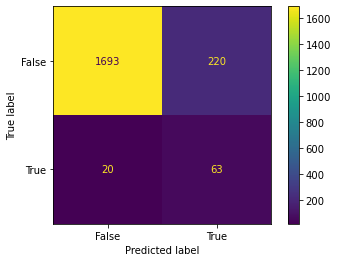

In [16]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

This matrix is a great reminder of how imbalanced our data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict `{"bankrupt": False}`, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, we can evaluate our model using two new metrics: **precision** and **recall**.  The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. The *recall* score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes. 

Let's start with a report you can create with scikit-learn to calculate both metrics. Then we'll look at them one-by-one using a visualization tool we've built especially for the Data Science Lab.

In [27]:
VimeoVideo("696297886", h="fac5454b22", width=600)

**Task 5.4.14:** Print the classification report for your model, using the test set.

- [Generate a classification report with scikit-learn.](../%40textbook/14-ml-classification.ipynb#Classification-Report)

In [17]:
# Print classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1913
        True       0.22      0.76      0.34        83

    accuracy                           0.88      1996
   macro avg       0.61      0.82      0.64      1996
weighted avg       0.96      0.88      0.91      1996



In [30]:
VimeoVideo("696220837", h="f93be5aba0", width=600)

In [32]:
VimeoVideo("696220785", h="8a4c4bff58", width=600)

**Task 5.4.15:** Run the cell below to load the confusion matrix widget.

- [What's precision?](../%40textbook/14-ml-classification.ipynb#Precision-Score)
- [What's recall?](../%40textbook/14-ml-classification.ipynb#Recall-Score)

In [18]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

If you move the probability threshold, you can see that there's a tradeoff between precision and recall. That is, as one gets better, the other suffers. As a data scientist, you'll often need to decide whether you want a model with better precision or better recall. What you choose will depend on how to intend to use your model.

Let's look at two examples, one where recall is the priority and one where precision is more important. First, let's say you work for a regulatory agency in the European Union that assists companies and investors navigate [insolvency proceedings](https://en.wikipedia.org/wiki/Insolvency_Regulation). You want to build a model to predict which companies could go bankrupt so that you can send debtors information about filing for legal protection before their company becomes insolvent. The administrative costs of sending information to a company is €500. The legal costs to the European court system if a company doesn't file for protection before bankruptcy is €50,000.

For a model like this, we want to focus on **recall**, because recall is all about *quantity*. A model that prioritizes recall will cast the widest possible net, which is the way to approach this problem. We want to send information to as many potentially-bankrupt companies as possible, because it costs a lot less to send information to a company that might not become insolvent than it does to skip a company that does. 

In [33]:
VimeoVideo("696209314", h="36a14b503c", width=600)

**Task 5.4.16:** Run the cell below, and use the slider to change the probability threshold of your model. What relationship do you see between changes in the threshold and changes in wasted administrative and legal costs? In your opinion, which is more important for this model: high precision or high recall?

- [What's precision?](../%40textbook/14-ml-classification.ipynb#Precision-Score)
- [What's recall?](../%40textbook/14-ml-classification.ipynb#Recall-Score)

In [19]:
c.show_eu()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

For the second example, let's say we work at a private equity firm that purchases distressed businesses, improve them, and then sells them for a profit. You want to build a model to predict which companies will go bankrupt so that you can purchase them ahead of your competitors. If the firm purchases a company that is indeed insolvent, it can make a profit of €100 million or more. But if it purchases a company that isn't insolvent and can't be resold at a profit, the firm will lose €250 million. 

For a model like this, we want to focus on **precision**. If we're trying to maximize our profit, the *quality* of our predictions is much more important than the *quantity* of our predictions. It's not a big deal if we don't catch every single insolvent company, but it's *definitely* a big deal if the companies we catch don't end up becoming insolvent.

This time we're going to build the visualization together. 

In [20]:
VimeoVideo("696209348", h="f7e1981c9f", width=600)

Profit: $7800000000
Losses: $212750000000


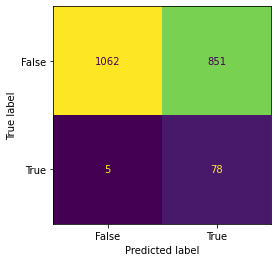

In [38]:
threshold=0.2
y_pred_proba=model.predict_proba(X_test)[:,-1]
y_pred=y_pred_proba>threshold
conf_matrix=confusion_matrix(y_test,y_pred)
tn,fp,fn,tp=conf_matrix.ravel()
print(f"Profit: ${tp *100_000_000}")
print(f"Losses: ${fp *250_000_000}")
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False)

**Task 5.4.17:** Create an interactive dashboard that shows how company profit and losses change in relationship to your model's probability threshold. Start with the `make_cnf_matrix` function, which should calculate and print profit/losses, and display a confusion matrix. Then create a FloatSlider `thresh_widget` that ranges from 0 to 1. Finally combine your function and slider in the `interact` function.

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [What's a confusion matrix?](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix)
- [Create a confusion matrix using scikit-learn.](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix) 

In [39]:
def make_cnf_matrix(threshold):
    
  
    y_pred_proba=model.predict_proba(X_test)[:,-1]
    y_pred=y_pred_proba>threshold
    conf_matrix=confusion_matrix(y_test,y_pred)
    tn,fp,fn,tp=conf_matrix.ravel()
    print(f"Profit: ${tp *100_000_000}")
    print(f"Losses: ${fp *250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False)


thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

<div class="alert alert-info" role="alert">
    <b>Go Further:</b>💡 Some students have suggested that this widget would be better if it showed the sum of profits and losses. Can you add that total?
</div>

# Communicate

Almost there! Save the best model so we can share it with other people, then put it all together with what we learned in the last lesson.

**Task 5.4.18:** Using a context manager, save your best-performing model to a file named `"model-5-4.pkl"`. 

- [What's serialization?](../%40textbook/03-pandas-getting-started.ipynb#Pickle-Files)
- [Store a Python object as a serialized file using pickle.](../%40textbook/03-pandas-getting-started.ipynb#Pickle-Files) 

In [22]:
# Save model
with open("model-5-4.pkl","wb") as f:
    pickle.dump(model,f)

In [40]:
VimeoVideo("696220731", h="8086ff0bcd", width=600)

**Task 5.4.19:** Open the file `my_predictor_lesson.py`, add the `wrangle` and `make_predictions` functions from the last lesson, and add all the necessary import statements to the top of the file. Once you're done, save the file. You can check that the contents are correct by running the cell below. 

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)

In [41]:
%%bash

cat my_predictor_lesson.py

# Import libraries
import gzip
import json
import pickle

import pandas as pd


# Add wrangle function from lesson 5.4
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df


# Add make_predictions function from lesson 5.3
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath,"rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred,index=X_test.index,name="bankrupt")
    return y_test_pred


Congratulations: You've created your first module!

In [42]:
VimeoVideo("696220643", h="8a3f141262", width=600)

**Task 5.4.20:** Import your `make_predictions` function from your `my_predictor` module, and use the code below to make sure it works as expected. Once you're satisfied, submit it to the grader.  

In [43]:
# Import your module
from my_predictor_lesson import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-4.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34     True
36    False
40     True
Name: bankrupt, dtype: bool

In [44]:
wqet_grader.grade(
    "Project 5 Assessment",
    "Task 5.4.20",
    make_predictions(
        data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
        model_filepath="model-5-4.pkl",
    ),
)

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
